In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2

!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/drive/MyDrive/Dataset_Covid/COVID-19_Radiography_Dataset'

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders
input_folder = '/content/drive/MyDrive/Covid19_Dataset/COVID-19_Radiography_Dataset'
splitfolders.ratio( input_folder,
                   output="/content/drive/MyDrive/output",seed=1337,ratio=(0.7,0.2,0.1))

Copying files: 21165 files [1:31:36,  3.85 files/s]


In [7]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 14814 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [8]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [9]:
from tensorflow.keras.applications.densenet import DenseNet169 
base_model = DenseNet169(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

for layer in base_model.layers:
    layer.trainable=False

51888128/51877672 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img,img_to_array
!pip3 install resnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for resnet: filename=resnet-0.1-py3-none-any.whl size=10042 sha256=80aea4e3ad3c037be238e8f5866c4506a55c43a06fc7228d02b18b95f6c0e30f
  Stored in directory: /root/.cache/pip/wheels/38/23/58/6e83e34ced7d4772b88e2e86305f94a1ca497bd87937f5e7ec
Successfully built resnet


In [11]:
DenseNet169_MODEL=Sequential()
DenseNet169_MODEL.add(base_model)
DenseNet169_MODEL.add(Dropout(0.5))
DenseNet169_MODEL.add(tf.keras.layers.GlobalAveragePooling2D())
DenseNet169_MODEL.add(Flatten())
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Dense(64,kernel_initializer='he_uniform'))
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Activation('relu'))
DenseNet169_MODEL.add(Dropout(0.5))
DenseNet169_MODEL.add(Dense(64,kernel_initializer='he_uniform'))
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Activation('relu'))
DenseNet169_MODEL.add(Dropout(0.5))
DenseNet169_MODEL.add(Dense(64,kernel_initializer='he_uniform'))
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Activation('relu'))
DenseNet169_MODEL.add(Dropout(0.5))
DenseNet169_MODEL.add(Dense(32,kernel_initializer='he_uniform'))
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Activation('relu'))
DenseNet169_MODEL.add(Dropout(0.5))
DenseNet169_MODEL.add(Dense(32,kernel_initializer='he_uniform'))
DenseNet169_MODEL.add(BatchNormalization())
DenseNet169_MODEL.add(Activation('relu'))
DenseNet169_MODEL.add(Dense(4,activation='softmax'))

In [12]:
DenseNet169_MODEL.compile(optimizer= tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
DenseNet169_MODEL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                1

In [13]:
#For avoiding overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [14]:
DenseNet169_MODEL.compile(optimizer= Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = DenseNet169_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=100, verbose=1, callbacks=[early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
232/232 [==============================] - 250s 948ms/step - loss: 1.1731 - accuracy: 0.5047 - precision: 0.5989 - recall: 0.2826 - val_loss: 0.8174 - val_accuracy: 0.6819 - val_precision: 0.7580 - val_recall: 0.6196
Epoch 2/100
232/232 [==============================] - 213s 918ms/step - loss: 0.9112 - accuracy: 0.6503 - precision: 0.7459 - recall: 0.5306 - val_loss: 0.6978 - val_accuracy: 0.7176 - val_precision: 0.7823 - val_recall: 0.6470
Epoch 3/100
232/232 [==============================] - 217s 933ms/step - loss: 0.7997 - accuracy: 0.6946 - precision: 0.7921 - recall: 0.5866 - val_loss: 0.6118 - val_accuracy: 0.7762 - val_precision: 0.8455 - val_recall: 0.6985
Epoch 4/100
232/232 [==============================] - 212s 912ms/step - loss: 0.7255 - accuracy: 0.7307 - precision: 0.8147 - recall: 0.6387 - val_loss: 0.5237 - val_accuracy: 0.8429 - val_precision: 0.8836 - val_recall: 0.7462
Epoch 5/100
232/232 [==============================] - 211s 910ms/step - loss: 0.649

In [15]:
DenseNet169_MODEL.evaluate(test_set, verbose=1)


34/34 [==============================] - 11s 309ms/step - loss: 0.3058 - accuracy: 0.8995 - precision: 0.9049 - recall: 0.8938


[0.3057539165019989,
 0.8994808793067932,
 0.9049211740493774,
 0.8938178420066833]

In [16]:
DenseNet169_MODEL.save('DenseNet169.h5')

In [17]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     #history2.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [18]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.5047252774238586, 0.6503307819366455, 0.6946132183074951, 0.7306602001190186, 0.7687997817993164, 0.794383704662323, 0.8124746680259705, 0.8203726410865784, 0.831240713596344, 0.8347508907318115, 0.8393411636352539, 0.8419737815856934, 0.8459565043449402, 0.8498042225837708, 0.8496017456054688, 0.8507493138313293, 0.8556095361709595, 0.8570271134376526, 0.8574321866035461, 0.8604698181152344, 0.8620223999023438, 0.8631024956703186, 0.8597947955131531, 0.8616849184036255, 0.8631699681282043, 0.868097722530365, 0.8674902319908142, 0.8667476773262024, 0.8694478273391724, 0.8690428137779236, 0.8733630180358887, 0.8701228499412537, 0.8699203729629517, 0.8712704181671143, 0.874713122844696, 0.8728229999542236, 0.8758606910705566, 0.8729580044746399, 0.8749831318855286, 0.8757256865501404]
validation accuracy:  [0.6819470524787903, 0.7176275849342346, 0.7762287259101868, 0.842863917350769, 0.8487712740898132, 0.8629489541053772, 0.8759451508522034, 0.8799622058868408, 0.87689036

Text(0.5, 1.0, 'Training and Validation Accuracy')

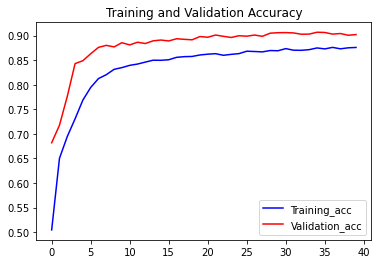

In [19]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

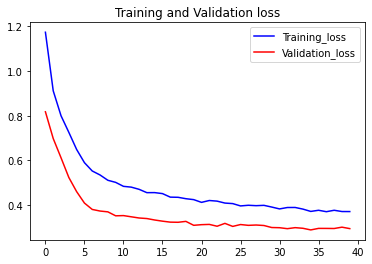

In [20]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

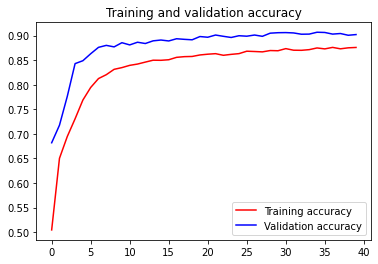

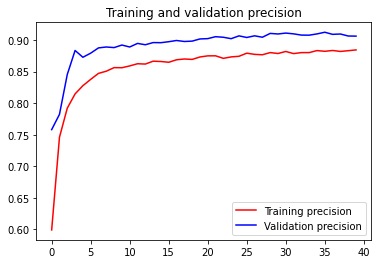

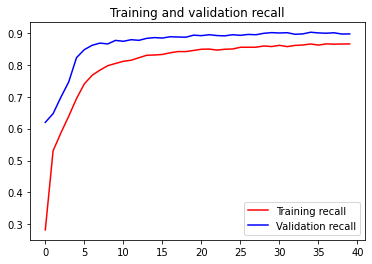

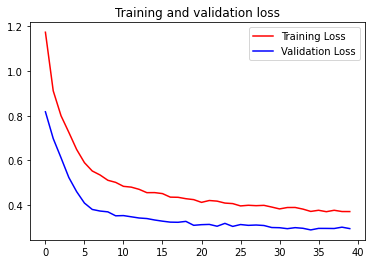

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
#model history
import pandas as pd
loss_df = pd.DataFrame(DenseNet169_MODEL.history.history)
loss_df

""


In [23]:
#prediction on test data
predictions = np.argmax(DenseNet169_MODEL.predict(test_set), axis = -1)

In [24]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       362
           1       0.89      0.83      0.86       602
           2       0.90      0.94      0.92      1020
           3       0.96      0.96      0.96       135

    accuracy                           0.90      2119
   macro avg       0.91      0.90      0.91      2119
weighted avg       0.90      0.90      0.90      2119



In [25]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[319  16  27   0]
 [ 27 502  73   0]
 [ 16  43 955   6]
 [  1   0   4 130]]
sensitivity: 0.9522
specificity: 0.9490


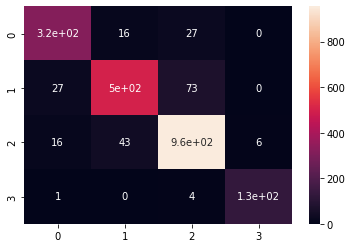

In [26]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))